# Visualização da Informação
## Escola de Matemática Aplicada - Fundação Getúlio Vargas
## Mestrado em Modelagem Matemática

Aluno: Gianlucca Devigili<br>
Github do projeto: https://github.com/GDevigili/chess-data-vis


# Trabalho Final: Briefing

In [1]:
# tratamento de dados
import pandas as pd

# carregando o dataset
df_chess = pd.read_csv('chess_games.csv')

### 1. Definir a curiosidade que originou a escolha da base 

A base de dados escolhida foi a [**Online Chess Games**](https://www.kaggle.com/mysarahmadbhat/online-chess-games) que contém dados referentes à 20.000 jogos de xadrez da plataforma [lichess.org](https://lichess.org/). A inspiração para a visualização é a série de visualizações presentes no artigo "[A Visual Look at 2 Million Chess Games](https://blog.ebemunk.com/a-visual-look-at-2-million-chess-games/)".$^1$

A ideia é criar um heatmap mostrando a posição das peças no tabuleiro em um determinado turno, além de usar transparência para mostrar turnos passados, permitindo assim observar a ocupação do tabuleiro e jogadas anteriores. Não pretendo usar dados de todos os jogos na visualização final, mas sim filtrar algumas aberturas, assim podendo analisar as respostas dos adversários à elas e também como estas variam, além de também fazer uma análise considerando os jogos de algum jogador com um ranking alto.

+ Hipótese sobre os dados 
    + determinadas aberturas ganham mais
    + jogadores com ranks maiores jogam de forma mais "cuidadosa" (jogos com menos capturas, a dominação do centro é mais importante)
+ Quem é o público alvo? 
    + entusiastas de xadrez que desejam analisar partidas
+ O que pode ser interessante de encontrar nos dados? 
    + padrões nas jogadas.
    + como diferentes jogadores ocupam as casas
    + como as aberturas variam a partir de alguns turnos
    + como são as respostas às aberturas
    
Obs:<br>
$^1$: _As referênciais visuais estão no fim do documento._

#### Esboço manual
este é um rascunho feito em um estágio bem inicial da idea, já pensei em algumas modificações depois de fazê-lo, mas acho válido adicioná-lo à este _briefing_.
![](https://raw.githubusercontent.com/GDevigili/chess-data-vis/main/visual_references/draft.jpeg)

### Documentar as circunstâncias 

**Restrições de prazo**
+ 13 de dezembro 

**Como a visualização será consumida:**

Pretendo criar uma interface com a biblioteca Streamlit do python de modo a permitir a interação com o gráfico
Opções de interação:
+ Slider para a seleção de turnos
+ Opções de filtragem (e.g. por peça, por cor, por jogador, por abertura)
+ (Extra) Input de texto permitindo o usuário inserir a(s) própria(s) partida(s) $^2$
   
**Quais são os entregáveis**
+ relatório do trabalho (.pdf)
+ interface streamlit (.html)

### Examinando a Base de Dados


In [6]:
print(df_chess.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [5]:
print(df_chess.head())

   game_id  rated  turns victory_status winner time_increment       white_id  \
0        1  False     13    Out of Time  White           15+2       bourgris   
1        2   True     16         Resign  Black           5+10           a-00   
2        3   True     61           Mate  White           5+10         ischia   
3        4   True     61           Mate  White           20+0  daniamurashov   
4        5   True     95           Mate  White           30+3      nik221107   

   white_rating      black_id  black_rating  \
0          1500          a-00          1191   
1          1322     skinnerua          1261   
2          1496          a-00          1500   
3          1439  adivanov2009          1454   
4          1523  adivanov2009          1469   

                                               moves opening_code  \
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...          D10   
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...          B00   
2  e4 e5 d3 d6 Be3 c6 Be2 b5 

A principal variável que desejo analisar é a `moves`, que contém a anotação dos movimentos da partida, por exemplo
> d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+ 

a ideia é transformar essas jogadas em um novo *dataframe* como o abaixo$^2$:

| game_id | turn | color | piece  | position | x | y |
|:---------|:------|:-------:|:--------:|:----------:|-----|-----|
| 1       | 1    | w     | rook   | a1       | 1 | 1 |
| 1       | 1    | w     | knight | b1       | 2 | 1 |
| 1       | 1    | w     | bishop | c1       | 2 | 1 |
| ...     | ...  | ...   | ...    | ...      | ... | ... |

outra variável que desejo analisar são os referentes às aberturas: `opening_shortname` e `opening_variation`, etc. que são variáveis categóricas e `opening_moves` que indica quantos movimentos foram usados para a abertura.
Outras variáveis importantes são `turns`, que indica quantos turnos teve a partida e `white_rating` e `black_rating`, indicando o ranking do jogador no site.

Obs:<br>
$^2$ *talvez alterações sejam necessárias de modo a facilitar o código, no momento o formato acima é apenas um rascunho*

### Imagens mentais

+ Faça uma seleção de referências visuais relacionadas ao projeto pretendido 

Algumas referências de inspiração:
+ **A visual look at 2 million chess games:** https://blog.ebemunk.com/a-visual-look-at-2-million-chess-games/
![](https://github.com/GDevigili/chess-data-vis/blob/main/visual_references/visual_reference_1.png?raw=true)
![](https://github.com/GDevigili/chess-data-vis/blob/main/visual_references/visual_reference_2.png?raw=true)
![](https://github.com/GDevigili/chess-data-vis/blob/main/visual_references/visual_reference_3.png?raw=true)

+ **Visualizing Chess Data With ggplot:** https://jkunst.com/blog/posts/2015-10-30-visualizing-chess-data-with-ggplot/
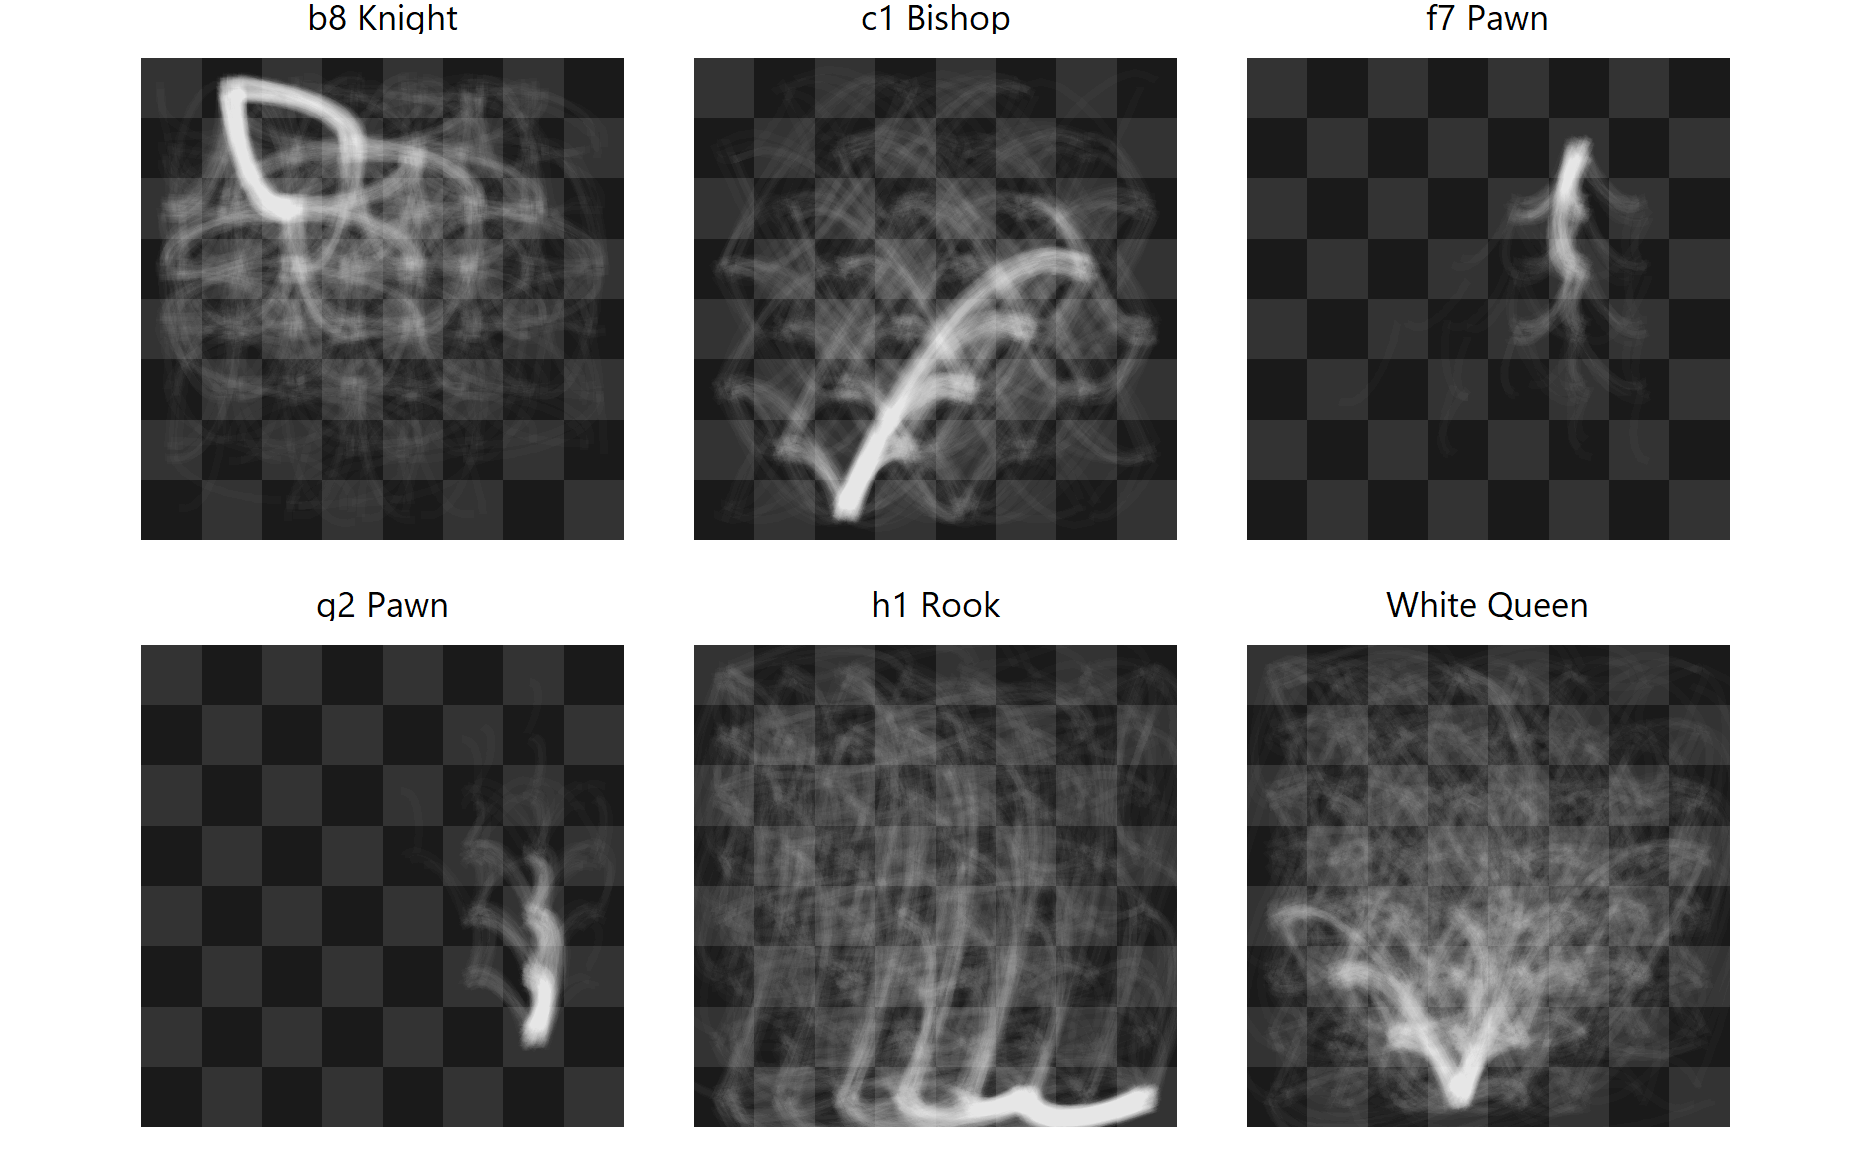
+ **Infographic: Visual Look at 2 million chess games (part 2):** https://infographic.tv/data-visualization-oc-visual-look-at-2-million-chess-games-part-2/
![](https://infographic.tv/wp-content/uploads/2019/01/data-visualization-OC-Visual-Look-at-2-Million-Chess-1007x999.jpg)

Outras visualizações que achei interessantes:
+ http://www.thefunctionalart.com/2016/05/visualizing-chess.html
+ https://www.reddit.com/r/HikaruNakamura/comments/ldhamy/i_created_a_visualization_on_chess_data_to/